### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt
import antropy as ant
import spkit as sp
import seaborn as sns
sns.set()
import EntropyHub as En

import warnings
from vmdpy import VMD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

### Read and preprocess data

In [2]:
EEG_78_CH2 = pd.read_csv('EEG_78_CH2.csv')
bis_78 = pd.read_csv('bis_78.csv')
B78=bis_78['BIS/BIS']
E78=EEG_78_CH2['BIS/EEG2_WAV']
print ('The shape of EEG signals and BIS for patient 78 is {} and {} '.format(E78.shape,B78.shape) )
print ('The type of EEG signals and BIS for patient 78 is {} and {} '.format(type(E78),type(B78)) )

The shape of EEG signals and BIS for patient 78 is (535191,) and (4180,) 
The type of EEG signals and BIS for patient 78 is <class 'pandas.core.series.Series'> and <class 'pandas.core.series.Series'> 


In [3]:
#checking for missing values

def missing_values(eeg_signal):

    # Check for missing values
    missing_values = np.isnan(eeg_signal)
    length_signals = len(eeg_signal)

    # Count the number of missing values
    num_missing_values = np.sum(missing_values)
    percentage_missing_values = (num_missing_values/length_signals)*100

    # Print the indices and values of missing values
    missing_indices = np.where(missing_values)[0]
    missing_values_list = eeg_signal[missing_indices]

    print("Missing Values:")
    print(f"Total Missing Values: {num_missing_values}")
    print(f"Percentage of Missing Values: {percentage_missing_values} %")  
missing_values(E78)

Missing Values:
Total Missing Values: 167
Percentage of Missing Values: 0.03120381321808476 %


In [4]:
E78_copy = np.copy(E78)

In [5]:
# Handling missing values

def handle_missing_values(signal):
    # Interpolate missing values using linear interpolation
    mask = np.isnan(signal)
    signal[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), signal[~mask])
    return signal
E78_copy=handle_missing_values(E78_copy)

### Selecting EEG signals

In [6]:
import numpy as np

# Assuming BIS and EEG are numpy arrays
BIS = B78
EEG = E78_copy

# Define the sampling frequency
fs = 128

# Define the indices for BIS range from 200 to 800
bis_start_index = 200
bis_end_index = 800

# Convert the BIS indices to EEG indices

eeg_start_index = bis_start_index * fs
eeg_end_index = bis_end_index * fs

# Select EEG values for BIS[200:800]
selected_EEG = EEG[eeg_start_index:eeg_end_index]
selected_bis = BIS[bis_start_index:bis_end_index]
selected_bis = np.array(selected_bis)
print(selected_EEG)


[-14.8  -12.6  -13.1  ... -21.3  -21.8  -20.45]


### Bandpass filtering

In [7]:
# Define the EEG signal
eeg_signal = selected_EEG # Replace with your actual EEG signal


# Define the filter function
def bandpass_filter(signal, lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# time in seconds
time = np.arange(len(eeg_signal)) / fs

# Apply bandpass filters to the EEG signal
bpass = bandpass_filter(eeg_signal, 0.01, 63.5, fs=128)




### Variational Mode Decomposition (VMD)

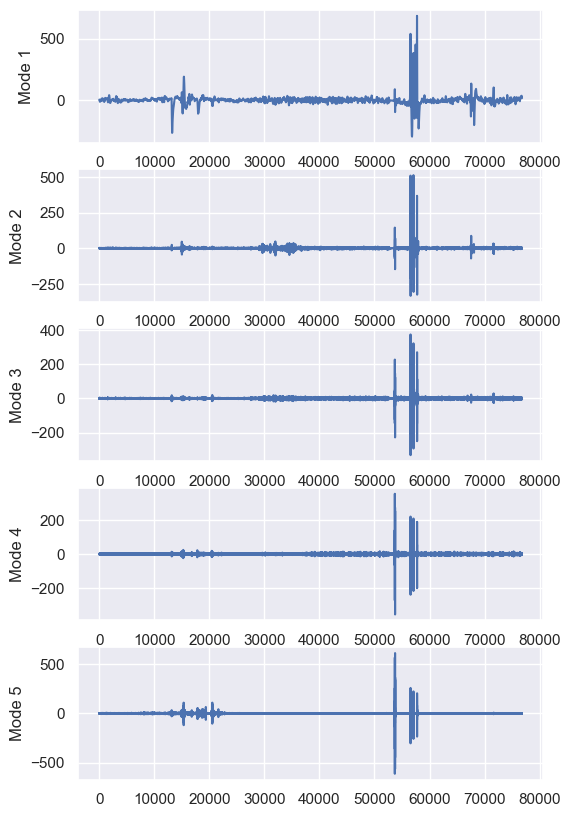

In [8]:
import numpy as np
from vmdpy import VMD

signal = bpass

# Set VMD parameters
alpha = 2000
tau = 0.5
K = 5
DC = 0
init = 1           # initialize omegas uniformly  
tol = 1e-7 

# Run VMD on the signal
modes, spectrum, omega =VMD (signal, alpha, tau, K, DC, init,tol)

#Plot the decomposed modes
import matplotlib.pyplot as plt
fig, axs = plt.subplots(K, 1, figsize=(6, 10))
for i in range(K):
    axs[i].plot(modes[i, :])
    axs[i].set_ylabel(f"Mode {i+1}")
plt.show()

### Windowing and features extraction

Number of BIS: 545


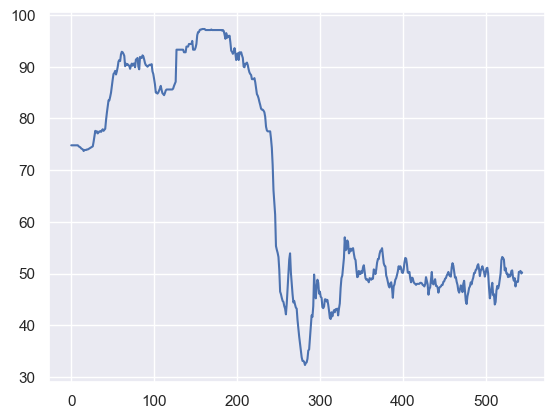

In [9]:


# For BIS

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    windows = []

    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end][0]
        windows.append(window)

    return windows

# Example usage
data = selected_bis  # Sample data
window_size_sec = 56.0       # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 1         # Sampling rate in samples per second

# Apply moving sliding window
bis_windows = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate)

# Print the number of windows and the shape of the first window
print("Number of BIS:", len(bis_windows))
plt.plot(bis_windows)
plt.show()


In [106]:
#### For entropies

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    
    result = []
    
    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end]
        

        if method == "Permutation entropy":
            # Calculate sample entropy within the window
            permutation_entropy = ant.perm_entropy(window)
            result.append(permutation_entropy)
            
        if method == "Dispersion entropy":
            # Calculate sample entropy within the window
            #Dispersion_entropy, prob =En.DispEn(window,classes=2, scale=3, emb_dim=8, delay=2,return_all=False)
            Dispersion_entropy, prob = sp.dispersion_entropy(window,classes=5, scale=5, emb_dim=8, delay=2,return_all=False)
            result.append(Dispersion_entropy)
            
        if method == "Fuzzy entropy":
            # Calculate sample entropy within the window
            Fuzzy_entropy, prob =En.FuzzEn(window)
            result.append(Fuzzy_entropy)
        
         # Detrended Fluctuation
        if method == "detf":
            detf = ant.detrended_fluctuation(window)
            result.append(detf)
            
            
             # Petrosian
        if method == "pet":
            pet = ant.petrosian_fd(window)
            result.append(pet)
            
            
             # hjorth-mobility
        if method == "hm":
            hm = ant.hjorth_params(window)[0]
            result.append(hm)
            
             # hjorth-complex
        if method == "hc":
            hc = ant.hjorth_params(window)[1]
            result.append(hc)
        
    return result


In [11]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultsdt_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='detf')
resultsdt_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='detf')
resultsdt_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='detf')
resultsdt_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='detf')
resultsdt_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='detf')
print(f"Number of features:", len(resultsdt_0))

Number of features: 545


In [12]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultspet_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='pet')
resultspet_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='pet')
resultspet_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='pet')
resultspet_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='pet')
resultspet_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='pet')
print(f"Number of features:", len(resultspet_0))

Number of features: 545


In [13]:



data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultshm_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='hm')
resultshm_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='hm')
resultshm_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='hm')
resultshm_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='hm')
resultshm_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='hm')
print(f"Number of features:", len(resultshm_0))

Number of features: 545


In [14]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultshc_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='hc')
resultshc_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='hc')
resultshc_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='hc')
resultshc_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='hc')
resultshc_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='hc')
print(f"Number of features:", len(resultshc_0))

Number of features: 545


In [15]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128        # Sampling rate in samples per second


# Apply moving sliding window and calculate sample entropies
resultsp_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')

print(f"Number of features:", len(resultsp_0))


Number of features: 545


In [107]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128        # Sampling rate in samples per second


# Apply moving sliding window and calculate sample entropies
resultsd_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
print(f"Number of features:", len(resultsd_0))


Number of features: 545


### Create Dataframe for each feature and find the correlation


In [17]:
# detf

df_detf = pd.DataFrame({'detf_mode0': resultsdt_0, 'detf_mode1': resultsdt_1, 'detf_mode2': resultsdt_2, 'detf_mode3': resultsdt_3, 'detf_mode4': resultsdt_4})

df_detf['BIS']=bis_windows
#df_detf


In [19]:
# pet

df_pet = pd.DataFrame({'pet_mode0': resultspet_0, 'pet_mode1': resultspet_1, 'pet_mode2': resultspet_2, 'pet_mode3': resultspet_3, 'pet_mode4': resultspet_4})

df_pet['BIS']=bis_windows
#df_pet



In [97]:
# hm

df_hm = pd.DataFrame({'hm_mode0': resultshm_0, 'hm_mode1': resultshm_1, 'hm_mode2': resultshm_2, 'hm_mode3': resultshm_3, 'hm_mode4': resultshm_4})

df_hm['BIS']=bis_windows
#df_hm


In [23]:
# hc

df_hc = pd.DataFrame({'hc_mode0': resultshc_0, 'hc_mode1': resultshc_1, 'hc_mode2': resultshc_2, 'hc_mode3': resultshc_3, 'hc_mode4': resultshc_4})

df_hc['BIS']=bis_windows
#df_hc


In [24]:
# Permutation entropy

df_perm = pd.DataFrame({'Perment_mode0': resultsp_0, 'Perment_mode1': resultsp_1, 'Perment_mode2': resultsp_2, 'Perment_mode3': resultsp_3, 'Perment_mode4': resultsp_4})

df_perm['BIS']=bis_windows
#df_perm

In [108]:
# Dispersion entropy

df_disp = pd.DataFrame({'Disp_mode0': resultsd_0, 'Disp_mode1': resultsd_1, 'Disp_mode2': resultsd_2, 'Disp_mode3': resultsd_3, 'Disp_mode4': resultsd_4})

df_disp['BIS']=bis_windows
#df_disp

In [26]:
metrics = {}
def plot_regression(data, column, normalize=False):
    
    global metrics
    
    X = data[column].values.reshape(-1, 1)
    #X = X[:, np.newaxis]
    y = data['BIS']

    # Perform regression
    reg = LinearRegression(n_jobs=-1).fit(X, y)
    
    # Predictions
    y_predicted = reg.predict(X)
    
    # Show the score and r2
    #mse = mean_squared_error(y, y_predicted)
    r2 = r2_score(y, y_predicted)
    
    # keep track of metrics
    
    #metrics["{}_mse".format(column)] = mse
    metrics["{}_r2".format(column)] = r2
    
    
    # Plot the graph
    plt.figure(figsize=(8,6))
    plt.scatter(data[column], data['BIS'], label="Data", c="steelblue")
    plt.plot(X, y_predicted, label="Regression", c="red")
    plt.xlabel(column)
    plt.ylabel('BIS')
    plt.legend(loc="upper left")
    plt.show()

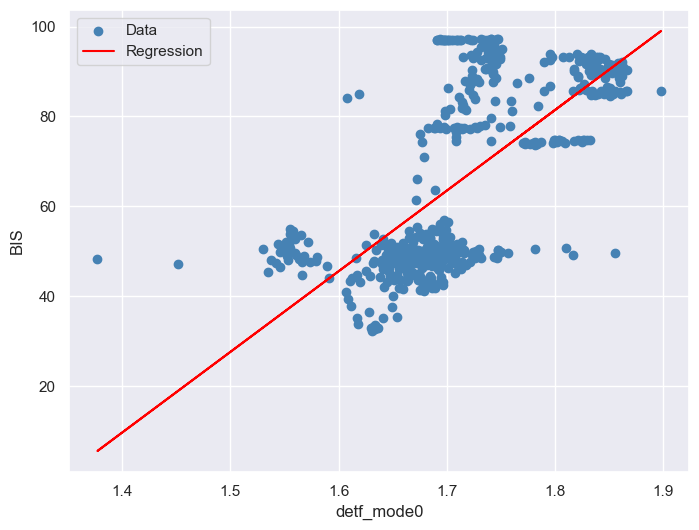

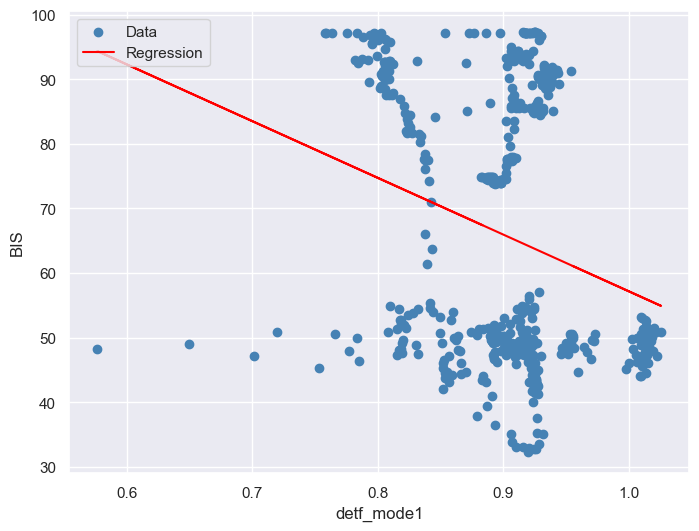

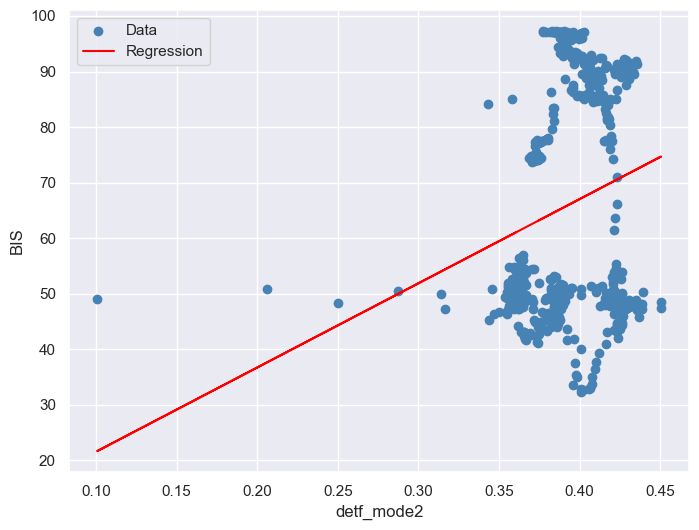

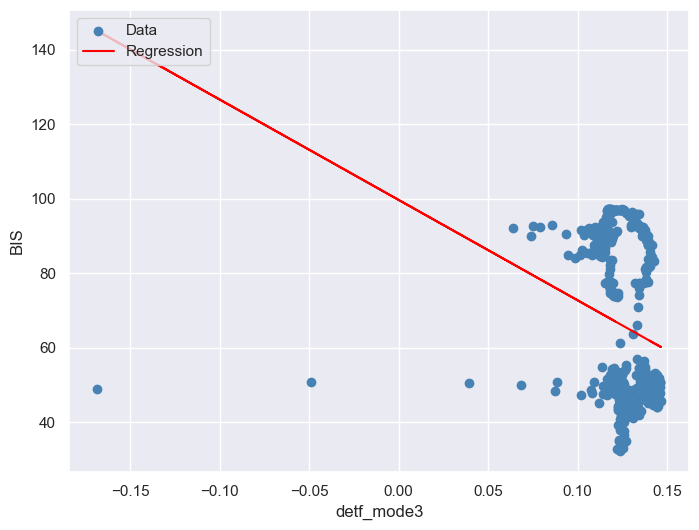

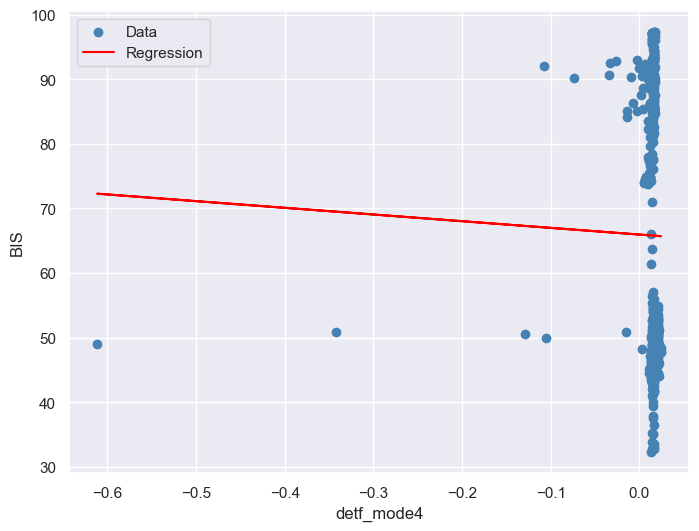

In [27]:
for column in df_detf.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_detf, column)

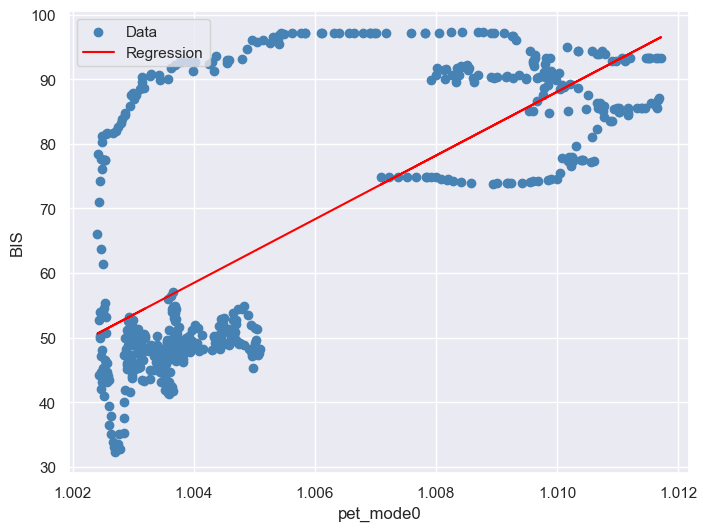

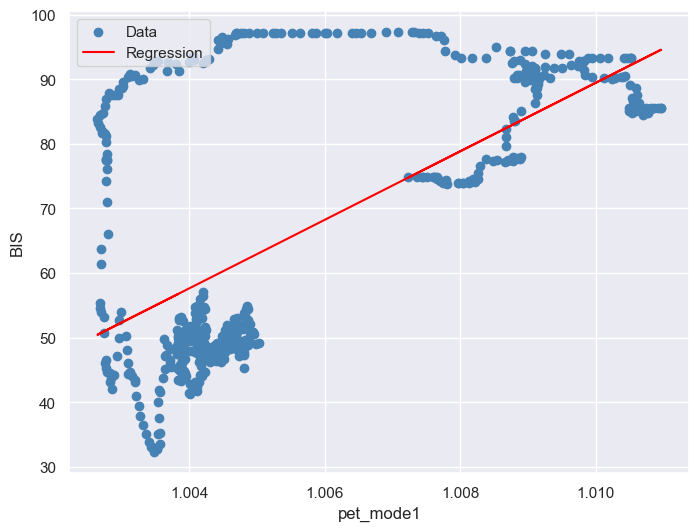

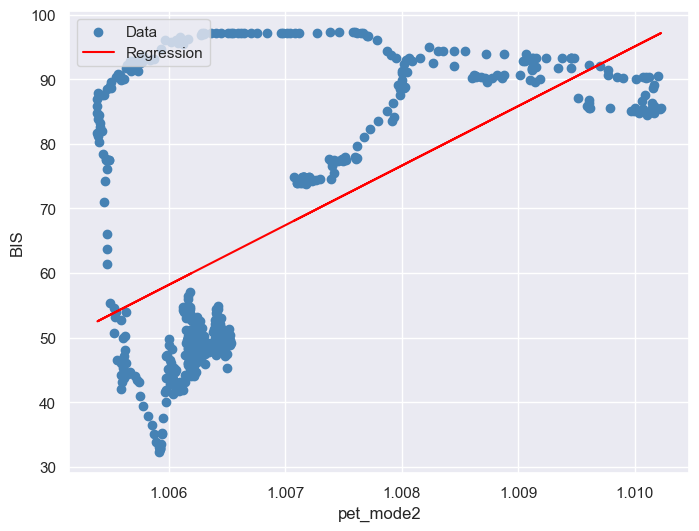

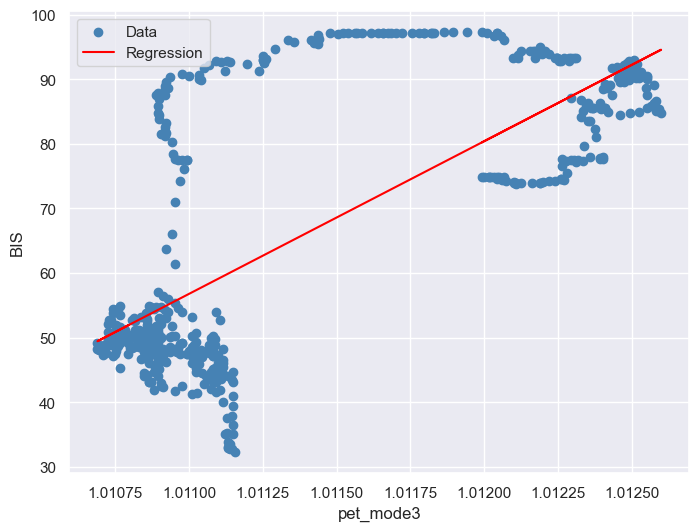

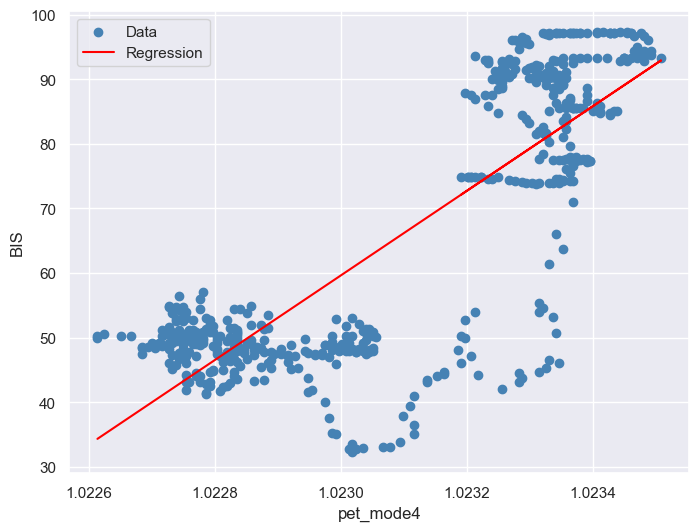

In [28]:
for column in df_pet.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_pet, column)

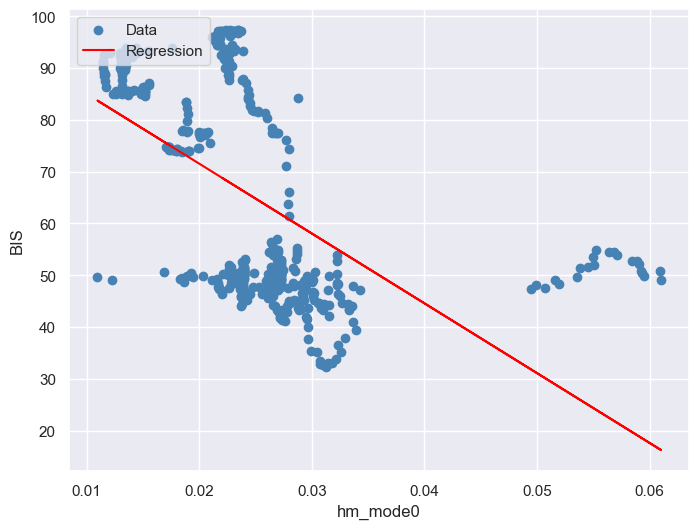

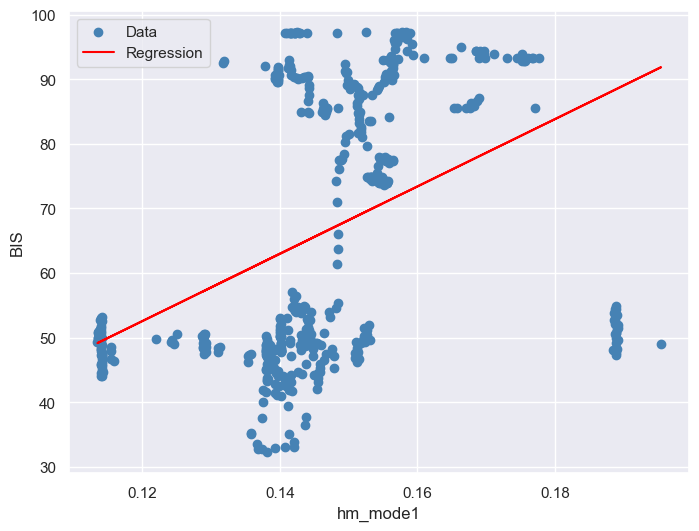

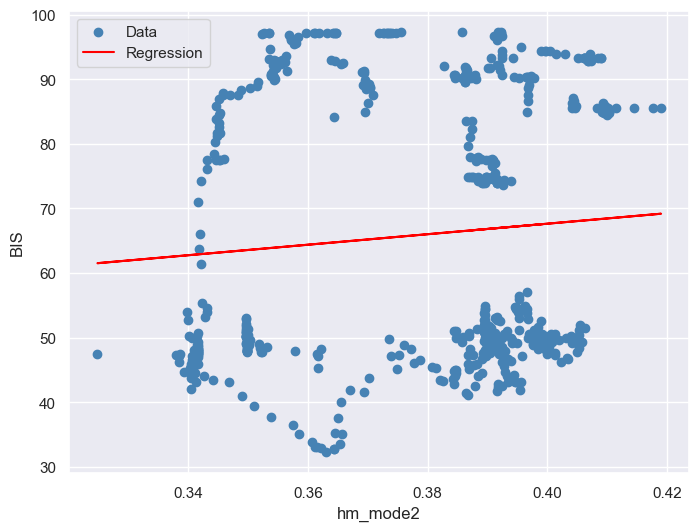

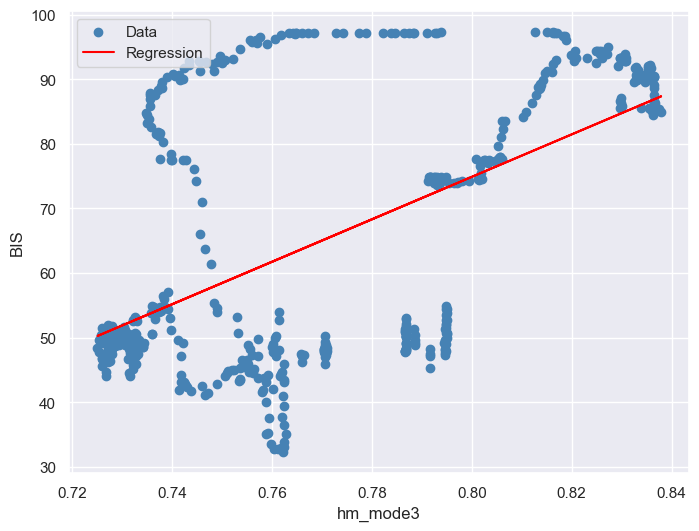

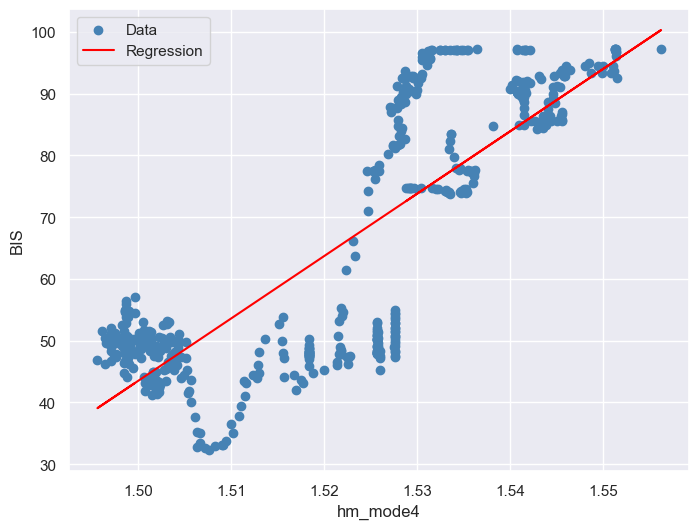

In [29]:
for column in df_hm.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_hm, column)

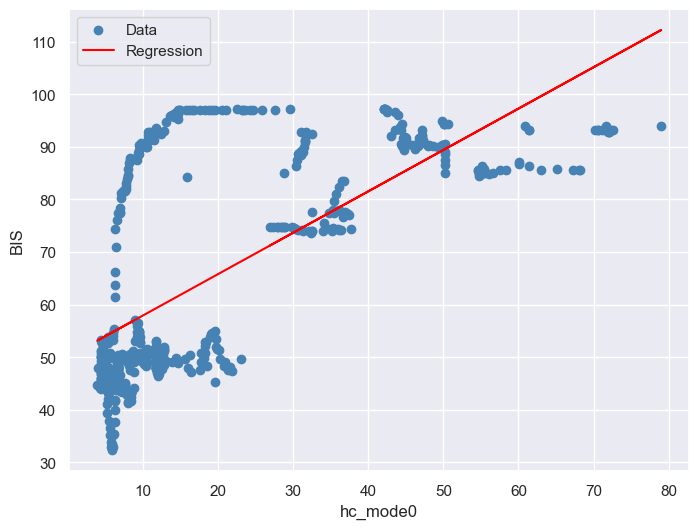

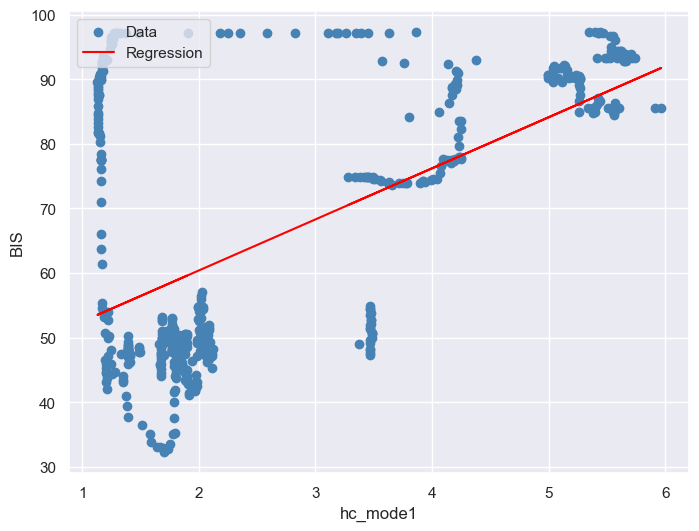

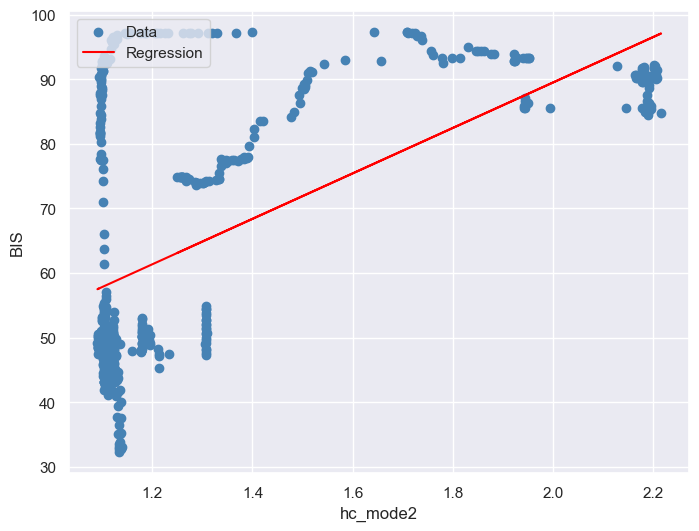

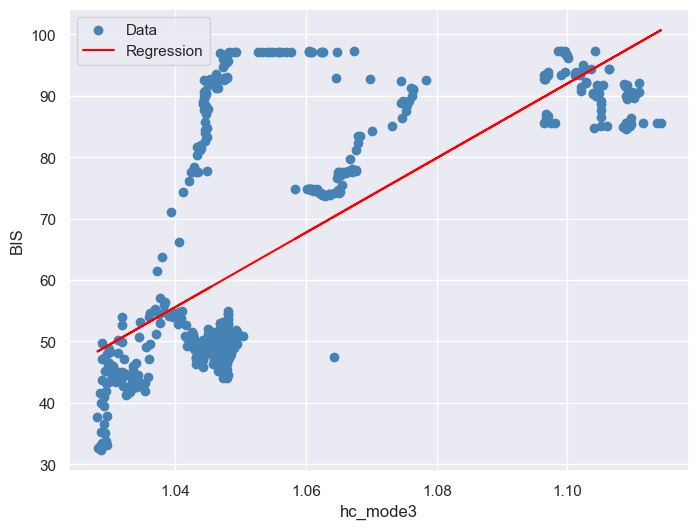

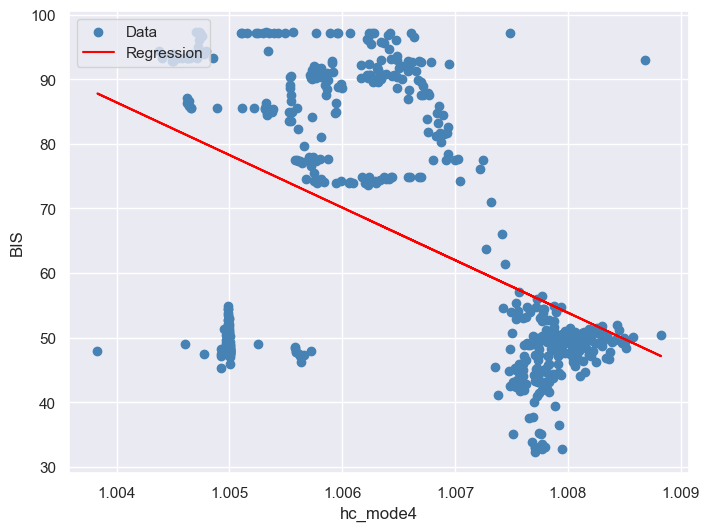

In [30]:
for column in df_hc.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_hc, column)

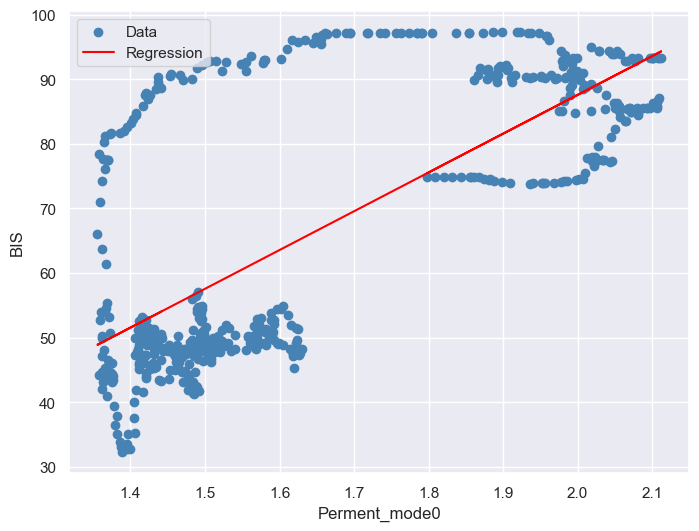

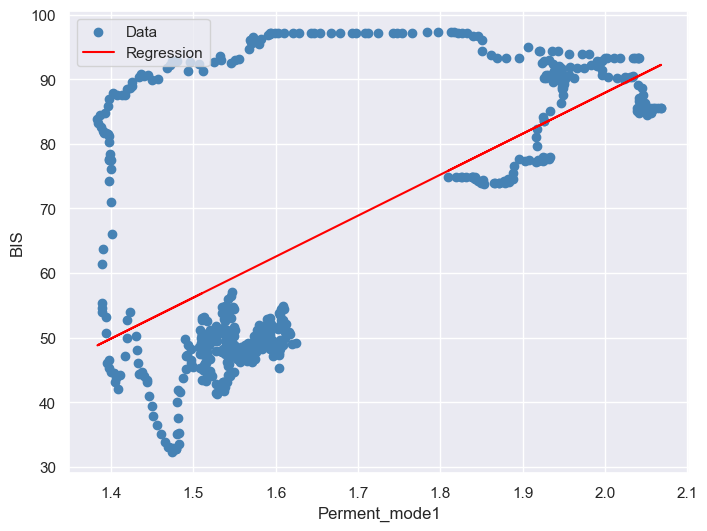

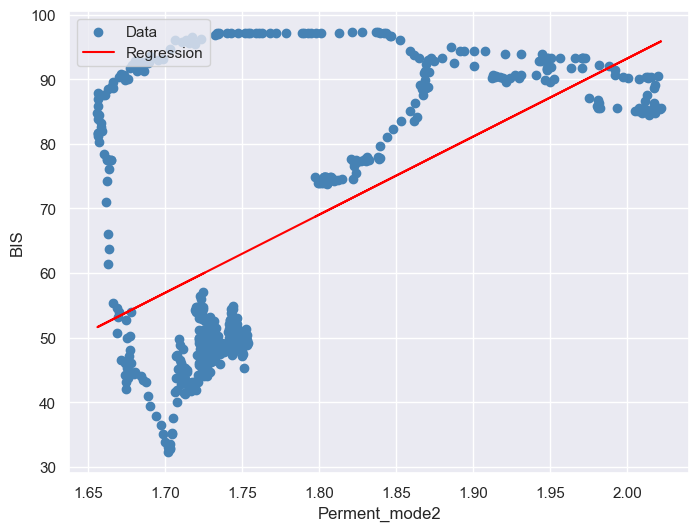

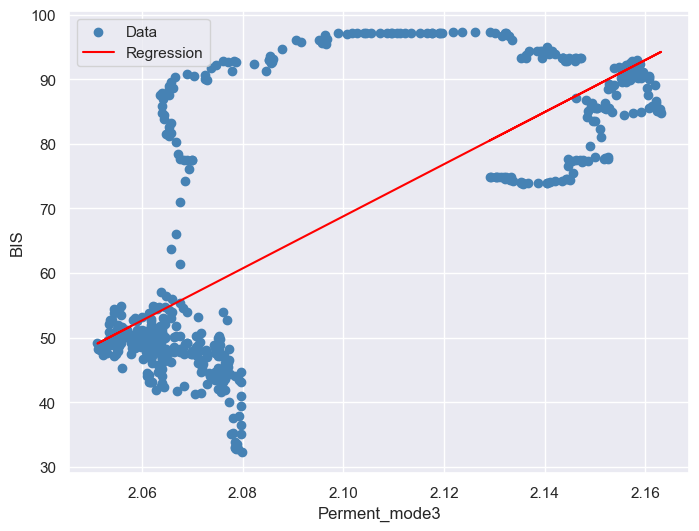

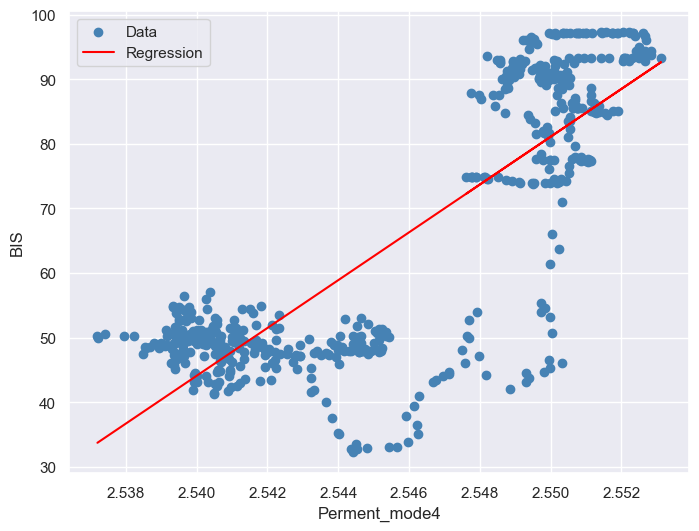

In [31]:
for column in df_perm.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_perm, column)
    
# Metrics
#pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value for value in metrics.values()]})

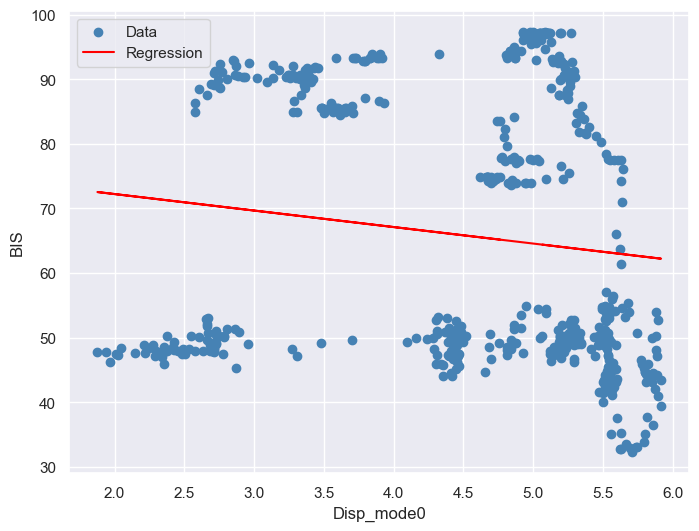

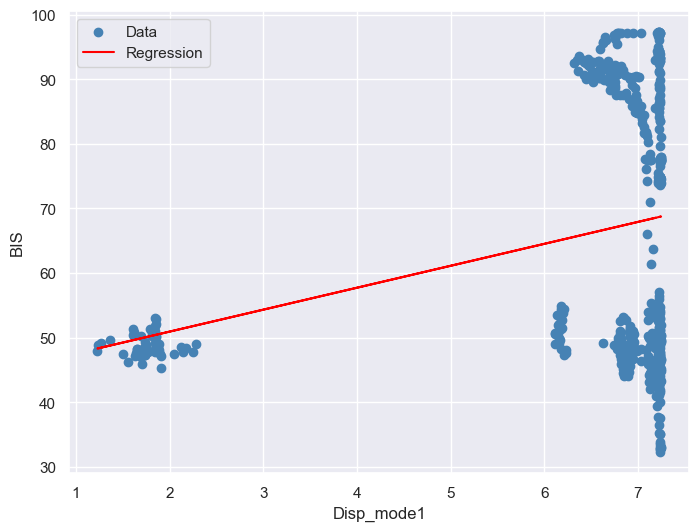

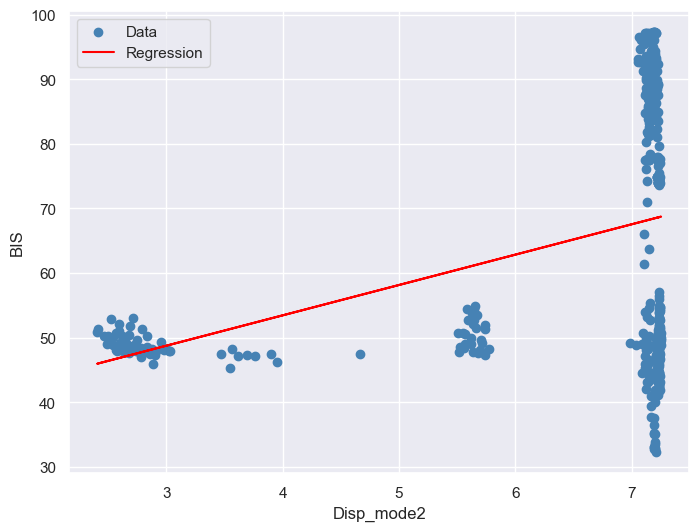

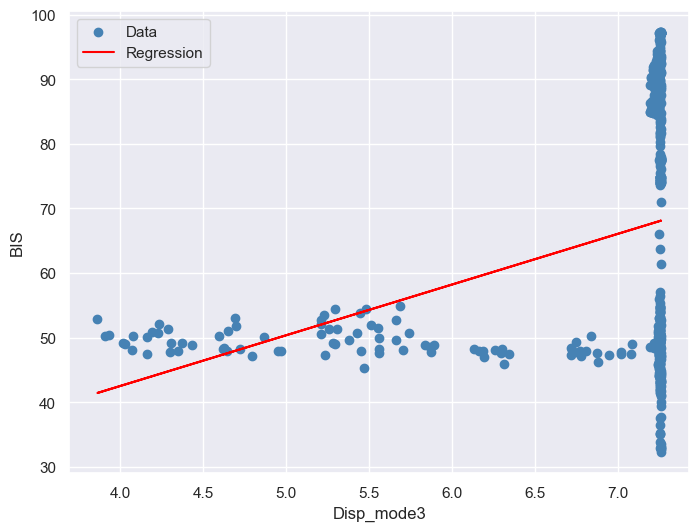

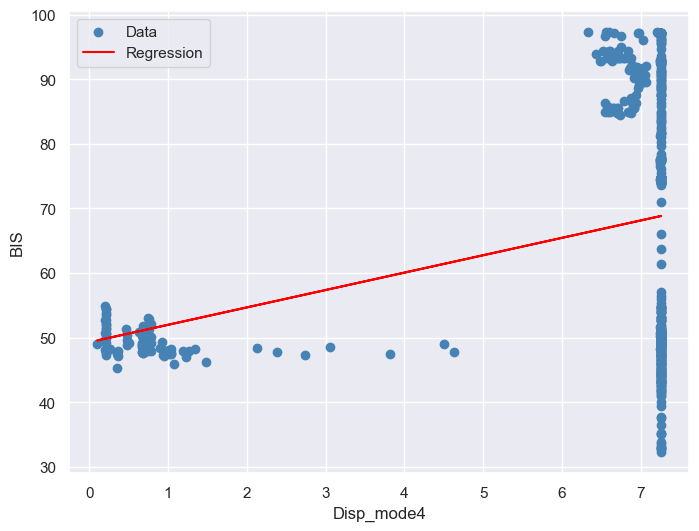

In [109]:
for column in df_disp.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_disp, column)
    
# Metrics
#pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value for value in metrics.values()]})

In [110]:
# Metrics
total=pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value*100 for value in metrics.values()]})

In [111]:
sort_total=total.sort_values('Values', ascending=False)
sort_total

,Metrics,Values
14,hm_mode4_r2,68.781304
24,Perment_mode4_r2,68.631651
9,pet_mode4_r2,68.399375
23,Perment_mode3_r2,55.627753
8,pet_mode3_r2,55.284579
20,Perment_mode0_r2,51.708453
5,pet_mode0_r2,50.927560
18,hc_mode3_r2,50.875147
15,hc_mode0_r2,47.436735
0,detf_mode0_r2,46.517040


In [112]:
com1=pd.DataFrame({'hm_mode4_r2':resultshm_4, 'Perment_mode4_r2': resultsp_4,  'disp_mode4_r2':resultsd_4})

In [113]:
com2=pd.DataFrame({'hm_mode4_r2':resultshm_4, 'Pet_mode4_r2': resultspet_4,  'disp_mode4_r2':resultsd_4})

In [114]:
com3=bukk=pd.DataFrame({'hm_mode4_r2':resultshm_4, 'Perment_mode4_r2': resultsp_4,  'disp_mode4_r2':resultsd_4})

In [115]:
com1=com1[['hm_mode4_r2','Perment_mode4_r2', 'disp_mode4_r2']]
new_y=df_hm['BIS']


mm1 = LinearRegression(n_jobs=-1).fit(com1, new_y)
    
# Predictions
y_pred1 = mm1.predict(com1)
    
# Show the score and r2
mse = mean_squared_error(new_y, y_pred1)
r2 = r2_score(new_y, y_pred1)
    

print("Multiple regression model Slope = %s, and intercept =%s"%(mm1.coef_,mm1.intercept_))
print('R_Squared_value for the multiple regression model: ', r2*100)
print('MSE_value for the multiple regression model: ', mse)

Multiple regression model Slope = [1241.27846189 -741.1639255     3.83333367], and intercept =39.843845782863596
R_Squared_value for the multiple regression model:  84.4610136006118
MSE_value for the multiple regression model:  65.70145892037665


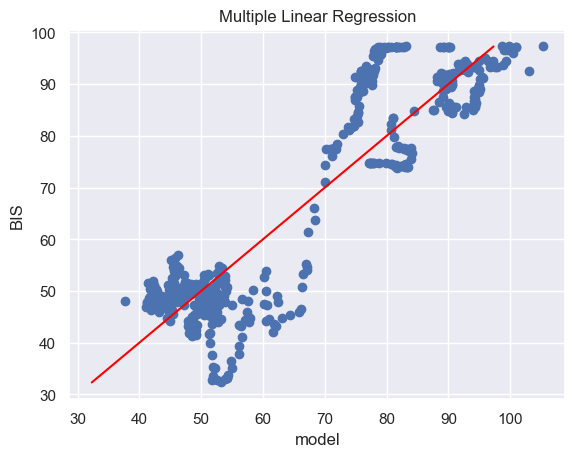

In [116]:
x1=com1['hm_mode4_r2']
x2=com1['Perment_mode4_r2']
x3=com1['disp_mode4_r2']

y_plot1 =mm1.coef_[0]*x1+mm1.coef_[1]*x2+mm1.coef_[2]*x3 +mm1.intercept_

plt.scatter(y_plot1, new_y)
plt.plot( [new_y.min(), new_y.max()], [new_y.min(), new_y.max()], label="Regression", c="red")

plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('model')
plt.show()


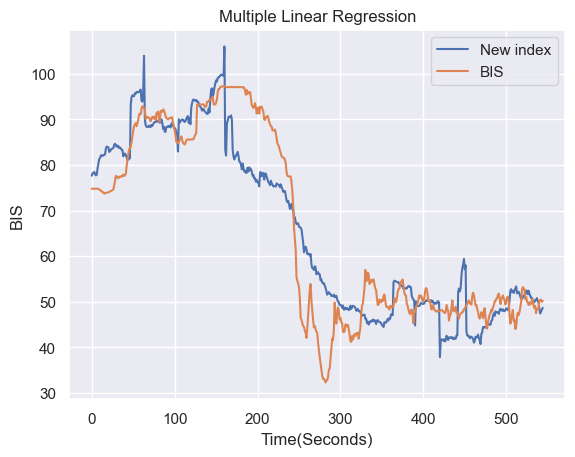

In [93]:
plt.plot(y_plot1, label='New index')
plt.plot(bis_windows,label ="BIS")
plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('Time(Seconds)')
plt.legend(loc="upper right")
plt.show()

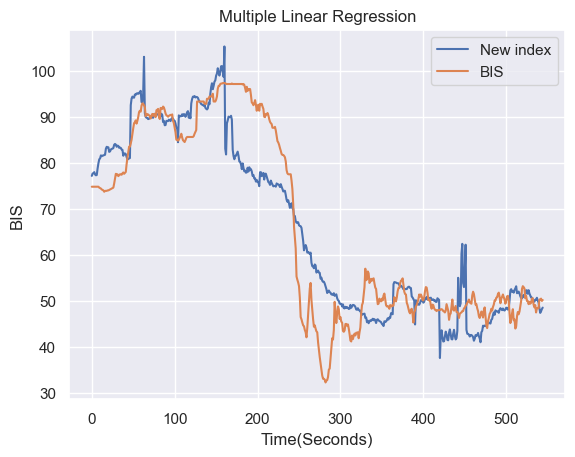

In [117]:
plt.plot(y_plot1, label='New index')
plt.plot(df_disp['BIS'],label ="BIS")
plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('Time(Seconds)')
plt.legend(loc="upper right")
plt.show()

In [118]:
#combine=buk[['Perment_mode3', 'detf_mode1_r2', 'pet_mode3_r2', 'hm_mode2_r2', 'hc_mode1_r2', 'Disp_mode4_r2']]
gud=pd.DataFrame({'Perment_mode0_r2':resultsp_0, 'Perment_mode1_r2':resultsp_1, 'Perment_mode2_r2':resultsp_2, 'Perment_mode3_r2':resultsp_3, 'Perment_mode4_r2':resultsp_4,
                 'detf_mode0_r2':resultsdt_0, 'detf_mode1_r2':resultsdt_1, 'detf_mode2_r2':resultsdt_2, 'detf_mode3_r2':resultsdt_3, 'detf_mode4_r2':resultsdt_4,
                 'pet_mode0_r2':resultspet_0,'pet_mode1_r2':resultspet_1, 'pet_mode2_r2':resultspet_2, 'pet_mode3_r2':resultspet_3, 'pet_mode4_r2':resultspet_4,
                 'hm_mode0_r2':resultshm_0, 'hm_mode1_r2':resultshm_1, 'hm_mode2_r2':resultshm_2, 'hm_mode3_r2':resultshm_3, 'hm_mode4_r2':resultshm_4,
                 'hc_mode0_r2':resultshc_0, 'hc_mode1_r2':resultshc_1, 'hc_mode2_r2':resultshc_2, 'hc_mode3_r2':resultshc_3, 'hc_mode4_r2':resultshc_4,
                  'disp_mode0_r2':resultsd_0, 'disp_mode1_r2':resultsd_1, 'disp_mode2_r2':resultsd_2, 'disp_mode3_r2':resultsd_3, 'disp_mode4_r2':resultsd_4 
                 })


gud=gud[['hc_mode1_r2','disp_mode4_r2', 'detf_mode4_r2']]
new_y=df_hm['BIS']


mm = LinearRegression(n_jobs=-1).fit(gud, new_y)
    
# Predictions
y_pre = mm.predict(gud)
    
# Show the score and r2
mse = mean_squared_error(new_y, y_pre)
r2 = r2_score(new_y, y_pre)
    

print("Multiple regression model Slope = %s, and intercept =%s"%(mm.coef_,mm.intercept_))
print('R_Squared_value for the multiple regression model: ', r2*100)

Multiple regression model Slope = [7.58282637 2.2177242  4.30376956], and intercept =31.7961036758918
R_Squared_value for the multiple regression model:  40.68572971032211
